Flux with MNIST and GPU


Libraries

In [111]:
using CUDA

using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLDataUtils          # label, nlabel, labelfreq, stratifiedobs
using Flux                 # the julia ml library

using Plots; gr()
using Random
using DataFrames

In [112]:
include( expanduser("~/projects/pesquisa/libs/libml.jl") )

stopTrainingCriteria (generic function with 1 method)

MNIST

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

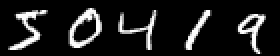

In [113]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2)  ; nrow=1)

In [114]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = MLDataUtils.stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

Preprocessing

In [115]:
# Flux works with matrices and vectors
function preprocess(X, y)
    Xs = permutedims(X, (2, 1, 3))
    Xs = Float32.(Xs) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N  = size(trainX); d = h * v

X_tr_c, y_tr_c = preprocess(trainX, trainY)
X_tr           = X_tr_c |> gpu
y_tr           = y_tr_c |> gpu

X_ts_c, y_ts_c = preprocess(testX, testY)
X_ts           = X_ts_c |> gpu
y_ts           = y_ts_c |> gpu;

Model

In [116]:
# model configuration
nInputs  = d
nOutputs = 10

# Flux.Dense(nInputs, 256, tanh)
model = Chain( Dense(nInputs => 128, relu),
               Dense(128     => 32,  relu),
               Dense(32      => nOutputs),
               softmax)      |> gpu                                   # weights on gpu

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 32, relu),               # 4_128 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 104_938 parameters, 856 bytes.

In [117]:
lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
dataset            = Flux.DataLoader((X_tr, y_tr), batchsize=1024)       # batchsize=1 => SGD, batch size > 1 => batch gradient descent
modelOptimizer     = Flux.Descent()

Descent(0.1)

In [118]:
predictOutcome(X) = Flux.onecold( model(X), [0:9;] )

predictOutcome (generic function with 1 method)

Training

In [119]:
numberOfEpochs = 500000

500000

Training epoch with plotting, with the aid of homemade function trainModel!

In [120]:
# https://fluxml.ai/Flux.jl/stable/training/training/

epochs     = 1 : numberOfEpochs
loss_tr    = Vector{Float64}()
loss_ts    = Vector{Float64}()
minLoss    = 1e-7   # hint: start at 1e-2, then go lower for more epochs (5e-4)
nearZero   = minLoss / 25

for epoch in epochs
    # train epoch
    loss = trainModel!( lossFunction, modelParameters, dataset, modelOptimizer )   # libml
    push!(loss_tr, loss)
    # print(".")   # "epoch completed" indicator

    # predict
    ŷ  = predictOutcome(X_ts)
    f1 = MLJ.multiclass_f1score(ŷ, coerce(testY, OrderedFactor))
    push!(loss_ts, f1)

    # exit criteria
    if stopTrainingCriteria(loss_tr, minLoss, nearZero)   break   end
end

loss function with small variation


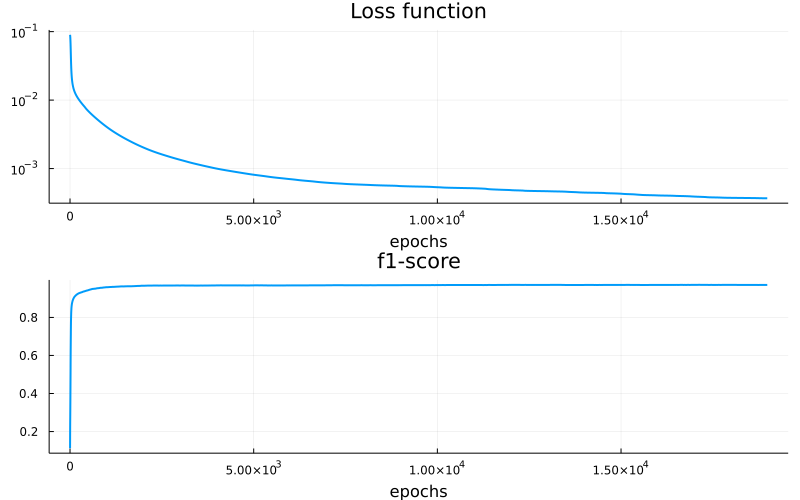

In [121]:
# plots
p1 = plotLoss(loss_tr, (800,500))
p2 = plot(1:size(loss_ts)[1], loss_ts,
    size        = (800,500),
    linewidth   = 2,
    # markershape = :circle,
    legend      = false,
    # xticks      = x,                   # force ticks to integer as the vector
    xlabel      = "epochs",
    # yaxis       = :log,
    title       = "f1-score")
plot(p1, p2, layout=(2,1), size=(800,500))